In [1]:
!pip install -U datasets #>=1.18.3
!pip install -U transformers #==4.17.0
!pip install -U evaluate
!pip install -U librosa
!pip install -U seaborn
!pip install -U jiwer

In [2]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()

WANDB_KEY = user_secrets.get_secret("wandb_key")

In [3]:
# from huggingface_hub import notebook_login
# notebook_login()

# Dataset

In [4]:
import json
from datasets import Dataset, DatasetDict, Audio, load_dataset
from tqdm.auto import tqdm
import random

import os
import numpy as np
import pandas as pd
import torchaudio

## Let's load dataset

In [5]:
DATA_PATH = '/kaggle/input/darpa-timit-acousticphonetic-continuous-speech/data/'
DATA_SPLIT = '/kaggle/input/timit-data-split/TIMIT_DATA_SPLIT.json'

In [6]:
with open(DATA_SPLIT, "r") as f:
    dataset = json.load(f)

dataset.keys()

dict_keys(['train', 'valid', 'test'])

### How many hours are in each set?
At least this helps us understand how big/small our dataset is.

In [7]:
# import librosa

# def get_durations(dict_data):
#     total_durations = 0

#     for entry in dict_data.values():
#         audio_data, _ = librosa.load(entry['audio_file'], sr=16_000)
#         duration = len(audio_data) / 16_000
#         total_durations += duration

#     return int(total_durations)

In [8]:
# print(f"Duration of Train: {get_durations(dataset['train']) // 60} mns")
# print(f"Duration of Valid: {get_durations(dataset['valid']) // 60} mns")
# print(f"Duration of Test : {get_durations(dataset['test']) // 60} mns")

# Preprocessing

## Process into HuggingFace Dataset Format

In [9]:
def convert_to_feature_dict(data_dict):
    # convert each feature into an array instead
    audio_files = []
    word_files = []
    phonetic_files = []
    for key, value in data_dict.items():
        audio_files.append(value['audio_file'])
        word_files.append(value['word_file'])
        phonetic_files.append(value['phonetic_file'])
    
    return {
        'audio_file': audio_files,
        'word_file': word_files,
        'phonetic_file': phonetic_files
    }

In [10]:
train = convert_to_feature_dict(dataset['train'])
valid = convert_to_feature_dict(dataset['valid'])
test  = convert_to_feature_dict(dataset['test'])

In [11]:
train_dataset = Dataset.from_dict(train)
valid_dataset = Dataset.from_dict(valid)
test_dataset = Dataset.from_dict(test)

In [12]:
print(train_dataset)

Dataset({
    features: ['audio_file', 'word_file', 'phonetic_file'],
    num_rows: 1440
})


## Read files for phonetics

In [13]:
def read_text_file(filepath):
    with open(filepath) as f:
        tokens = [line.split()[-1] for line in f]
        return " ".join(tokens)
    
def prepare_text_data(item):
    item['text'] = read_text_file(item['word_file'])
    item['phonetic'] = read_text_file(item['phonetic_file'])
    return item

In [ ]:
train_dataset = (train_dataset
                 .map(prepare_text_data)
                 .remove_columns(["word_file", "phonetic_file"]))
valid_dataset = (valid_dataset
                 .map(prepare_text_data)
                 .remove_columns(["word_file", "phonetic_file"]))
test_dataset  = (test_dataset
                 .map(prepare_text_data)
                 .remove_columns(["word_file", "phonetic_file"]))

Map:   0%|          | 0/1440 [00:00<?, ? examples/s]

Map:   0%|          | 0/240 [00:00<?, ? examples/s]

Map:   0%|          | 0/1680 [00:00<?, ? examples/s]

## Normalize the Phonetics

As we can see the result below, there are *61* phones. However, we don't need to use all of them. "tcl", for example, is just a pause where there is a "t". So, let's keep it up and simplify them a bit.

In [15]:
train_dataset

Dataset({
    features: ['audio_file', 'text', 'phonetic'],
    num_rows: 1440
})

In [ ]:
train_phonetics = [phone for x in train_dataset for phone in x['phonetic'].split()]
print("num of train phones:\t", len(set(train_phonetics)))

num of train phones:	 61


In [17]:
# TimitBet 61 phoneme mapping to 39 phonemes
# by Lee, K.-F., & Hon, H.-W. (1989). Speaker-independent phone recognition using hidden Markov models. IEEE Transactions on Acoustics, Speech, and Signal Processing, 37(11), 1641–1648. doi:10.1109/29.46546 
phon61_map39 = {
    'iy':'iy',  'ih':'ih',   'eh':'eh',  'ae':'ae',    'ix':'ih',  'ax':'ah',   'ah':'ah',  'uw':'uw',
    'ux':'uw',  'uh':'uh',   'ao':'aa',  'aa':'aa',    'ey':'ey',  'ay':'ay',   'oy':'oy',  'aw':'aw',
    'ow':'ow',  'l':'l',     'el':'l',  'r':'r',      'y':'y',    'w':'w',     'er':'er',  'axr':'er',
    'm':'m',    'em':'m',     'n':'n',    'nx':'n',     'en':'n',  'ng':'ng',   'eng':'ng', 'ch':'ch',
    'jh':'jh',  'dh':'dh',   'b':'b',    'd':'d',      'dx':'dx',  'g':'g',     'p':'p',    't':'t',
    'k':'k',    'z':'z',     'zh':'sh',  'v':'v',      'f':'f',    'th':'th',   's':'s',    'sh':'sh',
    'hh':'hh',  'hv':'hh',   'pcl':'h#', 'tcl':'h#', 'kcl':'h#', 'qcl':'h#','bcl':'h#','dcl':'h#',
    'gcl':'h#','h#':'h#',  '#h':'h#',  'pau':'h#', 'epi': 'h#','nx':'n',   'ax-h':'ah','q':'h#' 
}

def convert_phon61_to_phon39(sentence):
    tokens = [phon61_map39[x] for x in sentence.split()]
    return " ".join(tokens)

def normalize_phones(item):
    item['phonetic'] = convert_phon61_to_phon39(item['phonetic'])
    return item

In [ ]:
train_dataset = train_dataset.map(normalize_phones)
valid_dataset = valid_dataset.map(normalize_phones)
test_dataset = test_dataset.map(normalize_phones)

Map:   0%|          | 0/1440 [00:00<?, ? examples/s]

Map:   0%|          | 0/240 [00:00<?, ? examples/s]

Map:   0%|          | 0/1680 [00:00<?, ? examples/s]

In [ ]:
train_phonetics = [phone for x in train_dataset for phone in x['phonetic'].split()]
valid_phonetics = [phone for x in valid_dataset for phone in x['phonetic'].split()]
test_phonetics = [phone for x in test_dataset for phone in x['phonetic'].split()]

print("num of train phones:\t", len(set(train_phonetics)))
print("num of valid phones:\t", len(set(valid_phonetics)))
print("num of test phones:\t", len(set(test_phonetics)))

num of train phones:	 39
num of valid phones:	 39
num of test phones:	 39


## Phonetic Distribution
Let's check the distribution of each phone across all three test set. Note that we don't do simple counting. Instead, for each phoneme, we show the ratio of that phoneme relative to that specific set. On test set, obviously, the count of each phoneme is less than the train, but the ratio should be similar to the training set.

In [20]:
phone_vocabs = set(train_phonetics)
phone_vocabs.remove('h#')
phone_vocabs = sorted(phone_vocabs)

def count_frequency(phonetics):
    phone_counts = {phone: 0 for phone in phone_vocabs}
    for phone in phonetics:
        if phone in phone_vocabs:
            phone_counts[phone] += 1
    # eliminate h# for visualization purposes
    return [phone_counts[phone] for phone in phone_vocabs] 

In [21]:
train_phone_counts = count_frequency(train_phonetics)
valid_phone_counts = count_frequency(valid_phonetics)
test_phone_counts  = count_frequency(test_phonetics)

In [22]:
train_phone_ratio = [count / sum(train_phone_counts) for count in train_phone_counts]
valid_phone_ratio = [count / sum(valid_phone_counts) for count in valid_phone_counts]
test_phone_ratio  = [count / sum(test_phone_counts) for count in test_phone_counts]

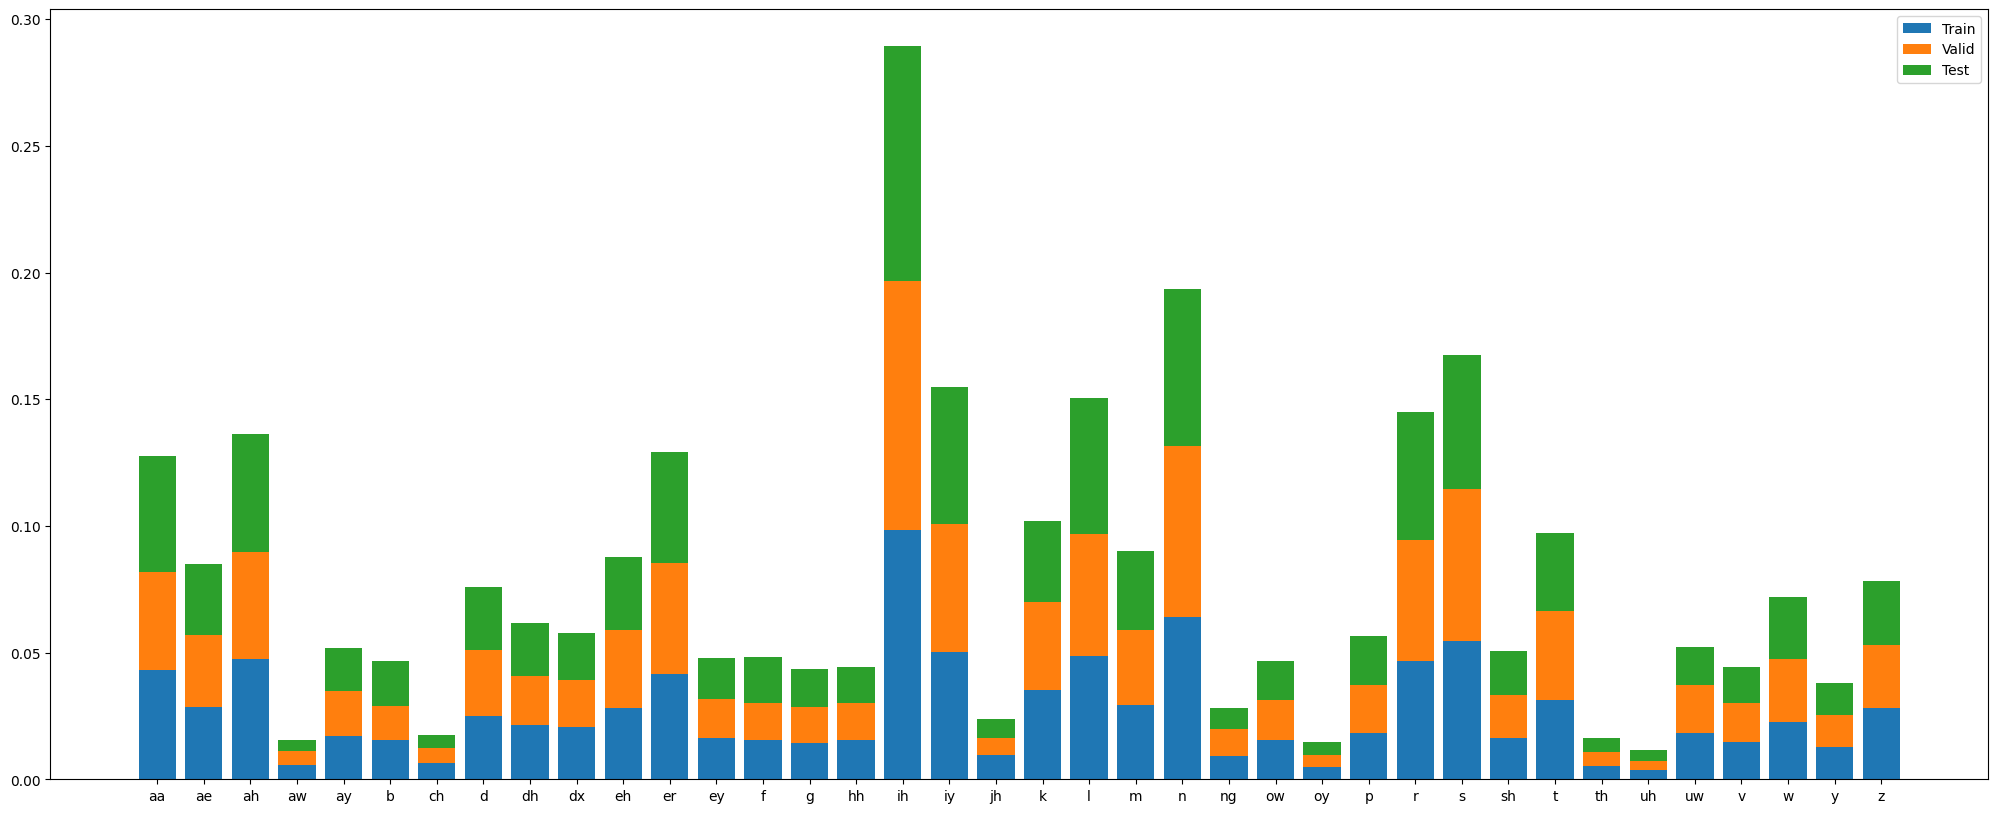

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(25,10))

plt.bar(phone_vocabs, train_phone_ratio, label="Train")
plt.bar(phone_vocabs, valid_phone_ratio, bottom=train_phone_ratio, label="Valid")
plt.bar(phone_vocabs, test_phone_ratio, bottom=[(x+y) for x,y in zip(train_phone_ratio, valid_phone_ratio)], label="Test")

plt.legend()

plt.show()

## Load Audio File

In [24]:
train_dataset = (train_dataset
                 .cast_column("audio_file", Audio(sampling_rate=16_000))
                 .rename_column('audio_file', 'audio'))
valid_dataset = (valid_dataset
                 .cast_column("audio_file", Audio(sampling_rate=16_000))
                 .rename_column('audio_file', 'audio'))
test_dataset = (test_dataset
                 .cast_column("audio_file", Audio(sampling_rate=16_000))
                 .rename_column('audio_file', 'audio'))

In [ ]:
train_dataset[0]

{'audio': {'path': '/kaggle/input/darpa-timit-acousticphonetic-continuous-speech/data/TRAIN/DR3/FALK0/SA1.WAV',
  'array': array([-9.15527344e-05,  2.74658203e-04,  1.22070312e-04, ...,
         -9.15527344e-05, -2.74658203e-04,  1.22070312e-04]),
  'sampling_rate': 16000},
 'text': 'she had your dark suit in greasy wash water all year',
 'phonetic': 'h# sh iy hh eh h# d y er h# d aa r h# k s uw h# h# ih n h# g r iy z iy w aa sh h# w aa dx er h# aa l y ih er h#'}

In [ ]:
import IPython.display as ipd
import numpy as np
import random

rand_int = random.randint(0, len(train_dataset)-1)

print("Text:", train_dataset[rand_int]["text"])
print("Phonetics:", train_dataset[rand_int]["phonetic"])
print("Input array shape:", train_dataset[rand_int]["audio"]["array"].shape)
print("Sampling rate:", train_dataset[rand_int]["audio"]["sampling_rate"])
ipd.Audio(data=train_dataset[rand_int]["audio"]["array"], autoplay=False, rate=16000)

Text: don't ask me to carry an oily rag like that
Phonetics: h# d ow n h# ae s h# m iy h# t ah h# k eh r iy ih n h# oy l iy r ae h# g l ay h# dh ae h# h#
Input array shape: (55706,)
Sampling rate: 16000


## Build Character Set

In [27]:
vocab_train = list(set(train_phonetics)) + [' ']
vocab_valid = list(set(valid_phonetics)) + [' ']
vocab_test  = list(set(test_phonetics)) + [' ']

In [28]:
vocab_list = list(set(vocab_train + vocab_valid + vocab_test))
vocab_dict = {v: k for k, v in enumerate(sorted(vocab_list))}

print(vocab_dict)

{' ': 0, 'aa': 1, 'ae': 2, 'ah': 3, 'aw': 4, 'ay': 5, 'b': 6, 'ch': 7, 'd': 8, 'dh': 9, 'dx': 10, 'eh': 11, 'er': 12, 'ey': 13, 'f': 14, 'g': 15, 'h#': 16, 'hh': 17, 'ih': 18, 'iy': 19, 'jh': 20, 'k': 21, 'l': 22, 'm': 23, 'n': 24, 'ng': 25, 'ow': 26, 'oy': 27, 'p': 28, 'r': 29, 's': 30, 'sh': 31, 't': 32, 'th': 33, 'uh': 34, 'uw': 35, 'v': 36, 'w': 37, 'y': 38, 'z': 39}


In [29]:
# make the space more intuitive to understand
vocab_dict["|"] = vocab_dict[" "]
del vocab_dict[" "]

vocab_dict["[UNK]"] = len(vocab_dict)
vocab_dict["[PAD]"] = len(vocab_dict)
len(vocab_dict)

42

In [30]:
# save vocab.json
import json
with open('/kaggle/working/vocab.json', 'w') as vocab_file:
    json.dump(vocab_dict, vocab_file)

# Modeling

## Input Processor

In [31]:
import json
import torch
from dataclasses import dataclass
from typing import Any, Dict, List, Union

In [51]:
# =============================================================================
# Select your SSL model here. Options include:
#   "facebook/wav2vec2-xls-r-300m"     (Wav2Vec2)
#   "facebook/hubert-large-ls960-ft"    (HuBERT)
#   "facebook/data2vec-audio-large-960h" (Data2Vec)
#   "microsoft/wavlm-base-plus"         (WavLM)
# =============================================================================
ssl_model = "facebook/hubert-large-ls960-ft"  

In [ ]:
# -----------------------------------------------------------------------------
# Load a custom CTC tokenizer (with your custom vocab.json)
# You previously saved your vocab in /kaggle/working/vocab.json.
# The tokenizer here is built for CTC tasks.
# -----------------------------------------------------------------------------
from transformers import Wav2Vec2CTCTokenizer

tokenizer = Wav2Vec2CTCTokenizer.from_pretrained(
    "/kaggle/working/",
    unk_token="[UNK]",
    pad_token="[PAD]",
    word_delimiter_token="|",
)

# -----------------------------------------------------------------------------
# Load the corresponding feature extractor.
# Using AutoFeatureExtractor allows us to switch models easily.
# We also explicitly set parameters (sampling_rate, normalization, etc.).
# -----------------------------------------------------------------------------
from transformers import AutoFeatureExtractor

feature_extractor = AutoFeatureExtractor.from_pretrained(
    ssl_model,
    feature_size=1,
    sampling_rate=16000,
    padding_value=0.0,
    do_normalize=True,
    return_attention_mask=True,
)   

# -----------------------------------------------------------------------------
# Create a processor combining the feature extractor and our custom tokenizer.
# Even though the class is named Wav2Vec2Processor, it works with similar architectures.
# -----------------------------------------------------------------------------
from transformers import Wav2Vec2Processor

processor = Wav2Vec2Processor(feature_extractor=feature_extractor, tokenizer=tokenizer)

In [53]:
# =============================================================================
# Prepare the dataset: this function processes each sample by:
#   - Converting the raw waveform using the processor,
#   - Recording the input length,
#   - Tokenizing the phonetic transcription into labels.
# =============================================================================
def prepare_dataset(batch):
    audio = batch["audio"]
    # Process the raw audio; we take the first (and only) element in the returned list.
    batch["input_values"] = processor(audio["array"], sampling_rate=audio["sampling_rate"]).input_values[0]
    batch["input_length"] = len(batch["input_values"])
    
    # Process the phonetic transcription into token ids.
    with processor.as_target_processor():
        batch["labels"] = processor(batch["phonetic"]).input_ids
    return batch

# Map the processing function over your datasets (train, valid, test).
# (If desired, you can remove columns by specifying remove_columns=train_dataset.column_names.)
train_dataset = train_dataset.map(prepare_dataset)
valid_dataset = valid_dataset.map(prepare_dataset)
test_dataset = test_dataset.map(prepare_dataset)

# =============================================================================
# Data Collator: Dynamically pads inputs and labels using the processor's pad method.
# Note: For labels, padded tokens are replaced with -100 to ignore them in loss computation.
# =============================================================================
@dataclass
class DataCollatorCTCWithPadding:
    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # Separate the input features and label sequences.
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        label_features = [{"input_ids": feature["labels"]} for feature in features]

        # Pad the input features (e.g., audio representations).
        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            return_tensors="pt",
        )

        # Pad the target labels.
        with self.processor.as_target_processor():
            labels_batch = self.processor.pad(
                label_features,
                padding=self.padding,
                return_tensors="pt",
            )

        # Replace padding tokens in labels with -100.
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)
        batch["labels"] = labels

        return batch

Map:   0%|          | 0/1440 [00:00<?, ? examples/s]

Map:   0%|          | 0/240 [00:00<?, ? examples/s]

Map:   0%|          | 0/1680 [00:00<?, ? examples/s]

## Evaluation Metrics

We use WER (Word Error Rate) and CER (Character Error Rate) to measure the performance of our model. After the training, we realize that WER may not be the right fit. CER fits better.

Note that CER here has some errors in our use case because each ARPAbet token is represented by one to three characters. For example, a label token is "ch" and another is "ae", that's two character error right there.

After the training, we will re-evaluate on test-set one more time, which we will evaluate at token level.

In [54]:
from evaluate import load

# Initialize the data collator.
data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True)
# wer_metric = load_metric("wer")
cer_metric = load("cer")

In [55]:
# =============================================================================
# Evaluation Metrics (using CER as an example)
# =============================================================================
from evaluate import load

cer_metric = load("cer")

def compute_metrics(pred):
    import numpy as np

    pred_logits = pred.predictions
    pred_ids = np.argmax(pred_logits, axis=-1)

    pred.label_ids[pred.label_ids == -100] = tokenizer.pad_token_id

    pred_str = tokenizer.batch_decode(pred_ids)
    label_str = tokenizer.batch_decode(pred.label_ids, group_tokens=False)
    
    cer = cer_metric.compute(predictions=pred_str, references=label_str)
    
    print("Predicted sample:", pred_str[0])
    print("Ground Truth sample:", label_str[0])
    return {"cer": cer}

In [58]:
# =============================================================================
# Model Initialization: Load a CTC model for the selected SSL model.
# AutoModelForCTC ensures that the correct architecture is loaded.
# Some dropout parameters may be model-specific.
# =============================================================================
from transformers import AutoModelForCTC

model = AutoModelForCTC.from_pretrained(
    ssl_model,
    attention_dropout=0.1,
    layerdrop=0.0,
    feat_proj_dropout=0.0,
    ctc_loss_reduction="mean",
    pad_token_id=processor.tokenizer.pad_token_id,
    vocab_size=len(processor.tokenizer),
    ignore_mismatched_sizes=True  
)

Some weights of HubertForCTC were not initialized from the model checkpoint at facebook/hubert-large-ls960-ft and are newly initialized because the shapes did not match:
- lm_head.weight: found shape torch.Size([32, 1024]) in the checkpoint and torch.Size([44, 1024]) in the model instantiated
- lm_head.bias: found shape torch.Size([32]) in the checkpoint and torch.Size([44]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [59]:
model

HubertForCTC(
  (hubert): HubertModel(
    (feature_extractor): HubertFeatureEncoder(
      (conv_layers): ModuleList(
        (0): HubertLayerNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
        (1-4): 4 x HubertLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
        (5-6): 2 x HubertLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): HubertFeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projection): Linear(in

In [60]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params:,}")

Total parameters: 315,483,820


In [43]:
# model.freeze_feature_encoder()

## Training

In [ ]:
import wandb
wandb.login(key=WANDB_KEY)

os.environ["WANDB_LOG_MODEL"] = "checkpoint"

# Initialize with team/entity
wandb.init(
    project="iasa-ucu-audio-processing",
    entity="BashHav", 
    name='hubert_test',
    settings=wandb.Settings(init_timeout=180) 
)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: ivanbashtovyi1 (IASA-BA-Diploma-Ivan-Bashtovyi). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


wandb: Currently logged in as: ivanbashtovyi1 (BashHav). Use `wandb login --relogin` to force relogin


In [47]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir='/kaggle/working/',
    group_by_length=True,
    per_device_train_batch_size=16,
    gradient_accumulation_steps=1,
    evaluation_strategy="steps",
    gradient_checkpointing=True,
    fp16=True,
    report_to='wandb',
    max_steps=1000,
    save_steps=200,
    eval_steps=100,
    logging_steps=20,
    learning_rate=1e-4,
    warmup_steps=20,
    save_total_limit=3,
    load_best_model_at_end=True
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [48]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    tokenizer=processor.feature_extractor
)

<ipython-input-48-828f3c8badd7>:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [49]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
/usr/local/lib/python3.10/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(


Step,Training Loss,Validation Loss,Cer
100,3.253900,3.220123,1.000000
200,1.812200,1.283380,0.457074
300,0.651800,0.474233,0.117412
400,0.466500,0.426773,0.125159
500,0.396300,0.387358,0.100902
600,0.351900,0.385181,0.100076
700,0.314200,0.383577,0.100521
800,0.272400,0.388754,0.092329


Predicted sample: 
Ground Truth sample: h#hhihzh#tahfh#h#aanihsh#tiyh#kihnh#dehm zihmh#tuwh#eysaalahh#tehriyh#ehnh#dihfihh#k lh#tihh#zihsh#tihnh#sh#
Predicted sample: h#hhh#th#nihsh#th#knh#dm zmh#th#slh#trh#nh#dihfh#klh#th#h#h# sh#tn s
Ground Truth sample: h#hhihzh#tahfh#h#aanihsh#tiyh#kihnh#dehm zihmh#tuwh#eysaalahh#tehriyh#ehnh#dihfihh#k lh#tihh#zihsh#tihnh#sh#


wandb: Adding directory to artifact (/kaggle/working/checkpoint-200)... Done. 25.0s
/usr/local/lib/python3.10/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(


Predicted sample: h#hhihzh#tahfh#aanihsh#tiyh#kihnh#dehm zhhihmh#tuwh#eysaalahh#tehriyh#ehnh#dihfahh#kahlh#th#ihh#g zihsh#tihn sh#h#h#h#
Ground Truth sample: h#hhihzh#tahfh#h#aanihsh#tiyh#kihnh#dehm zihmh#tuwh#eysaalahh#tehriyh#ehnh#dihfihh#k lh#tihh#zihsh#tihnh#sh#
Predicted sample: h#hhihzh#tahfh#aanihsh#tiyh#kihnh#dehm zihmh#tuwh#eysaalihh#tehriyh#aenh#dihfahh#kahlh#th#ihh#zihsh#tihnsh#h#h#
Ground Truth sample: h#hhihzh#tahfh#h#aanihsh#tiyh#kihnh#dehm zihmh#tuwh#eysaalahh#tehriyh#ehnh#dihfihh#k lh#tihh#zihsh#tihnh#sh#


wandb: Adding directory to artifact (/kaggle/working/checkpoint-400)... Done. 24.4s
/usr/local/lib/python3.10/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(


Predicted sample: h#hhihzh#tahfh#aanihsh#tiyh#kihnh#dehm zhhihmh#tuwh#eysaalihh#tehriyh#ehnh#dihfihh#k lh#th#ihh#g zihsh#tihnh#sh#
Ground Truth sample: h#hhihzh#tahfh#h#aanihsh#tiyh#kihnh#dehm zihmh#tuwh#eysaalahh#tehriyh#ehnh#dihfihh#k lh#tihh#zihsh#tihnh#sh#
Predicted sample: h#hhihzh#tahfh#aanihsh#tiyh#kihnh#dehm zihmh#tuwh#eysaalihh#tehriyh#ehnh#dihfahh#k lh#th#ihh#zihsh#tihnh#sh#h#h#
Ground Truth sample: h#hhihzh#tahfh#h#aanihsh#tiyh#kihnh#dehm zihmh#tuwh#eysaalahh#tehriyh#ehnh#dihfihh#k lh#tihh#zihsh#tihnh#sh#


wandb: Adding directory to artifact (/kaggle/working/checkpoint-600)... Done. 23.3s
/usr/local/lib/python3.10/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(


Predicted sample: h#hhihzh#tahfh#aanihsh#tiyh#kihnh#dehm zihmh#tuwh#eysaalahh#tehriyh#ehnh#dihfihh#k lh#th#ihh#g zihsh#tihn sh#h#
Ground Truth sample: h#hhihzh#tahfh#h#aanihsh#tiyh#kihnh#dehm zihmh#tuwh#eysaalahh#tehriyh#ehnh#dihfihh#k lh#tihh#zihsh#tihnh#sh#
Predicted sample: h#hhihzh#tahfh#aanihsh#tiyh#kihnh#dehm zihmh#tuwh#eysaalahh#tehriyh#ehnh#dihfihh#k lh#th#ihh#zihsh#tihn sh#
Ground Truth sample: h#hhihzh#tahfh#h#aanihsh#tiyh#kihnh#dehm zihmh#tuwh#eysaalahh#tehriyh#ehnh#dihfihh#k lh#tihh#zihsh#tihnh#sh#


wandb: Adding directory to artifact (/kaggle/working/checkpoint-800)... Done. 24.4s
/usr/local/lib/python3.10/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(


KeyboardInterrupt: 

In [61]:
wandb.finish()

eval/cer,█▄▁▁▁▁▁▁
eval/loss,█▃▁▁▁▁▁▁
eval/runtime,▁█▁▁▅▂█▃
eval/samples_per_second,█▁██▄▇▁▆
eval/steps_per_second,█▁██▄▇▁▆
train/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/global_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
train/grad_norm,▅▁▃▂▃▁▃▄▄█▆█▇▇▆▆█▅▇▇▆▅▆▃▄▆▅▄▆▅▅▃▂▄▅▅▅▄▆▆
train/learning_rate,▆███▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁
train/loss,█▄▄▄▄▄▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/cer,0.09233


## Evaluate on Test Set

In [48]:
trainer.evaluate(test_dataset)

The following columns in the evaluation set  don't have a corresponding argument in `Wav2Vec2ForCTC.forward` and have been ignored: text, phonetic, audio, input_length. If text, phonetic, audio, input_length are not expected by `Wav2Vec2ForCTC.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1680
  Batch size = 8


Predicted sample h#h#kh#kh#kh#h#h#h#h#
GT sample h#shiyhhaeh#d yerh#daarh#k suwdxihngh#g riysiywaashh#waadxerh#aal yiyerh#


{'eval_loss': 2.835930585861206,
 'eval_cer': 0.7327310734775442,
 'eval_runtime': 99.1109,
 'eval_samples_per_second': 16.951,
 'eval_steps_per_second': 2.119,
 'epoch': 3.33}

In [49]:
# trainer.evaluate(train_dataset)

## Save Model

In [50]:
# save locally
# trainer.save_model()

In [51]:
# trainer.push_to_hub(repo_name="vitouphy/wav2vec2-xls-r-300m-phoneme")

In [52]:
# tokenizer.push_to_hub('vitouphy/xls-r-300m-km')
# model.push_to_hub(repo_path_or_name='vitouphy/wav2vec2-xls-r-300m-phoneme')